# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [18]:
x = np.random.randn(500, 500) + 10
from cs231n.layers import dropout_forward

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print 'Running tests with p = ', p
  print 'Mean of input: ', x.mean()
  print 'Mean of train-time output: ', out.mean()
  print 'Mean of test-time output: ', out_test.mean()
  print 'Fraction of train-time output set to zero: ', (out == 0).mean()
  print 'Fraction of test-time output set to zero: ', (out_test == 0).mean()
  print

Running tests with p =  0.3
Mean of input:  9.99886035199
Mean of train-time output:  9.94155919418
Mean of test-time output:  9.99886035199
Fraction of train-time output set to zero:  0.70182
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  9.99886035199
Mean of train-time output:  9.98659674563
Mean of test-time output:  9.99886035199
Fraction of train-time output set to zero:  0.400712
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  9.99886035199
Mean of train-time output:  9.99161123168
Mean of test-time output:  9.99886035199
Fraction of train-time output set to zero:  0.250468
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [21]:
from cs231n.layers import dropout_backward

x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.89289661024e-11


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [35]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print 'Running check with dropout = ', dropout
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))
  print

Running check with dropout =  0
Initial loss:  2.30201448532
W1 relative error: 3.07e-07
W2 relative error: 1.37e-06
W3 relative error: 1.58e-06
b1 relative error: 2.39e-08
b2 relative error: 1.40e-08
b3 relative error: 1.85e-10

Running check with dropout =  0.25
Initial loss:  2.29970679578
W1 relative error: 2.30e-06
W2 relative error: 1.48e-08
W3 relative error: 2.61e-09
b1 relative error: 2.39e-08
b2 relative error: 1.81e-09
b3 relative error: 1.18e-10

Running check with dropout =  0.5
Initial loss:  2.28967802866
W1 relative error: 2.36e-06
W2 relative error: 4.20e-08
W3 relative error: 7.91e-09
b1 relative error: 5.21e-09
b2 relative error: 7.01e-10
b3 relative error: 9.51e-11



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [72]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.25, 0.5, 0.75]
learning_rates = [5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
for dropout in dropout_choices:
    for lr in learning_rates:
        
        print "------ dropout rate: {0} ------- lr: {1} ------".format(dropout, lr)
            
        model = FullyConnectedNet([50], dropout=dropout)
        
        solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=True, print_every=100)
        solver.train()
        key = str(dropout) + str(lr)
        solvers[key] = solver

------ dropout rate: 0 ------- lr: 0.05 ------
(Iteration 1 / 100) loss: 3.020665
(Epoch 0 / 20) train acc: 0.134000; val_acc: 0.129000
(Epoch 1 / 20) train acc: 0.162000; val_acc: 0.144000
(Epoch 2 / 20) train acc: 0.116000; val_acc: 0.106000
(Epoch 3 / 20) train acc: 0.264000; val_acc: 0.190000
(Epoch 4 / 20) train acc: 0.336000; val_acc: 0.201000
(Epoch 5 / 20) train acc: 0.384000; val_acc: 0.203000
(Epoch 6 / 20) train acc: 0.430000; val_acc: 0.233000
(Epoch 7 / 20) train acc: 0.464000; val_acc: 0.235000
(Epoch 8 / 20) train acc: 0.504000; val_acc: 0.261000
(Epoch 9 / 20) train acc: 0.512000; val_acc: 0.195000
(Epoch 10 / 20) train acc: 0.566000; val_acc: 0.231000
(Epoch 11 / 20) train acc: 0.638000; val_acc: 0.272000
(Epoch 12 / 20) train acc: 0.676000; val_acc: 0.255000
(Epoch 13 / 20) train acc: 0.726000; val_acc: 0.239000
(Epoch 14 / 20) train acc: 0.750000; val_acc: 0.254000
(Epoch 15 / 20) train acc: 0.750000; val_acc: 0.270000
(Epoch 16 / 20) train acc: 0.792000; val_acc: 0.

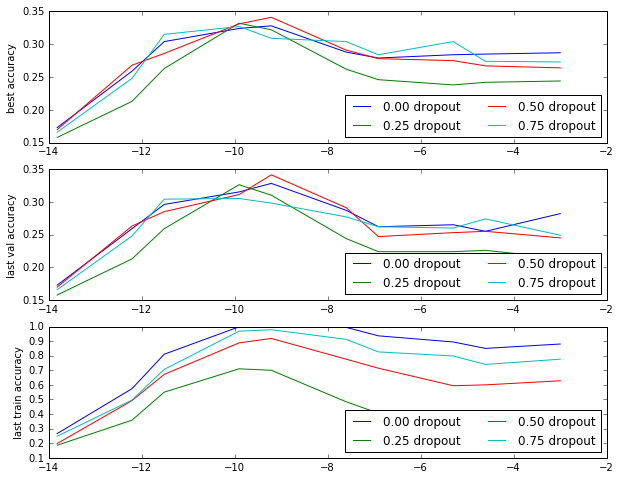

In [75]:
# here I plotted the best validation accuracy/ last validation accuracy/ last train accuracy during training 
# against learning rate used.It seems that higher dropout rate expand the range where certain learning rate "works generally well"
# 0.5 dropout rate generates the best val acc.

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    alist = []
    for lr in learning_rates:
        key = str(dropout) + str(lr)
        alist.append(max(solvers[key].val_acc_history))
    plt.plot(np.log(learning_rates), alist, label='%.2f dropout'%dropout)
    plt.legend(ncol=2, loc='lower right')
    plt.ylabel("best accuracy")

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    alist = []
    for lr in learning_rates:
        key = str(dropout) + str(lr)
        alist.append(solvers[key].val_acc_history[-1])
    plt.plot(np.log(learning_rates), alist, label='%.2f dropout'%dropout)
    plt.legend(ncol=2, loc='lower right')
    plt.ylabel("last val accuracy")

plt.subplot(3, 1, 3)
for dropout in dropout_choices:
    alist = []
    for lr in learning_rates:
        key = str(dropout) + str(lr)
        alist.append(solvers[key].train_acc_history[-1])
    plt.plot(np.log(learning_rates), alist, label='%.2f dropout'%dropout)
    plt.legend(ncol=2, loc='lower right')
    plt.ylabel("last train accuracy")


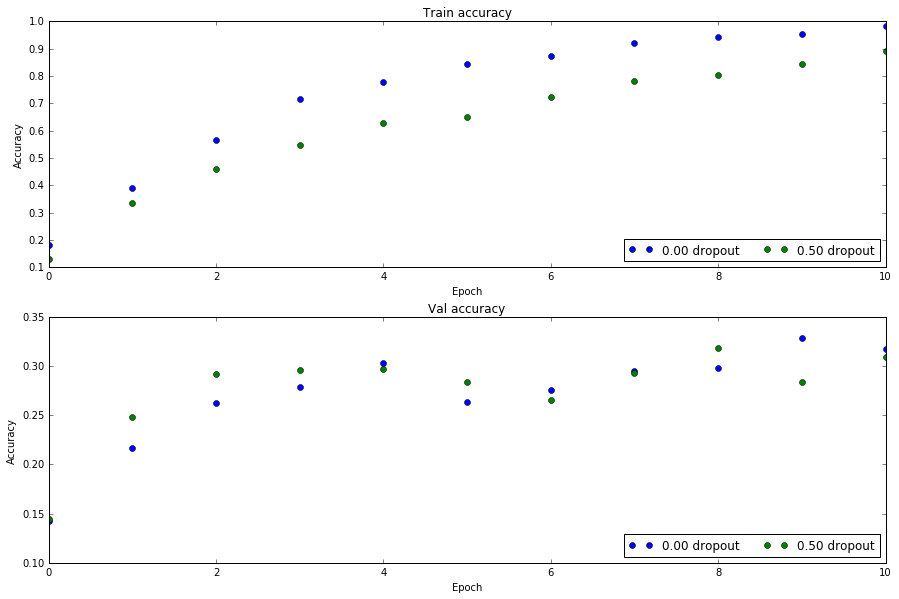

In [55]:
# Plot train and validation accuracies of the two models

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

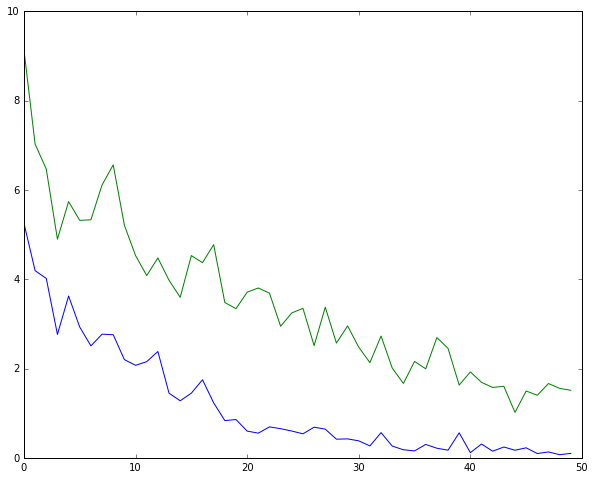

In [56]:
for dropout in dropout_choices:
  plt.plot(solvers[dropout].loss_history)

# Answer
